In [ ]:
'''
calculate monthly VCI for 2 NDVI products and compare
author: Sara Miller
'''

!pip install --upgrade pip --quiet

# try to import packages needed
try:
  import ee
  import folium
  from ee.ee_exception import EEException
  
  from google.colab import auth
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from oauth2client.client import GoogleCredentials


# if it doesn't work, install the packages...
except ImportError:
  !pip install -q earthengine-api
  !pip install -q folium
  !pip install -q bokeh
  
  # ...then import
  import ee
  import folium
  from ee.ee_exception import EEException


# import Python packages for utility
import numpy as np
import pandas as pd
import math
import datetime
from itertools import groupby
import geopandas as gpd
from shapely.geometry import shape
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
from matplotlib.patches import Patch

In [ ]:
# try to initialize Earth Engine session
try:
  ee.Initialize()

# if it doesn't work, then authorize an account for Earth Engine to connect to...
except EEException:
  !earthengine authenticate --quiet

  authCode = raw_input("Authorization code:")

  !earthengine authenticate --authorization-code=$authCode
  
  # ...then initialize session
  ee.Initialize()

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

Paste the following address into a web browser:

    https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com

On the web page, please authorize access to your Earth Engine account and copy the authentication code. Next authenticate with the following command:

    earthengine authenticate --authorization-code=PLACE_AUTH_CODE_HERE

Authorization code:4/wAFamunu1OT93lKmcCfTbL63TbFs2tWpPCGM7cMGTC_3DjYc55tmNkU
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API


Successfully saved authorization token.


In [ ]:
counties = ee.FeatureCollection('users/sem0029/Kenya_counties')
wards = ee.FeatureCollection('users/sem0029/kenya_ndma_wards')
subcounties = ee.FeatureCollection('users/sem0029/Kenya_subcounties')

#function to rescale NDVI from 0-200 to -1-1
def rescaleNDVI(img):
  ndvi = img.subtract(100).divide(100).rename('ndvi')
  return ndvi.updateMask(ndvi.gt(-1).And(ndvi.lt(1))).set('system:time_start',img.get('system:time_start'))


#get sMODIS and eMODIS and rescale NDVI
smodis = ee.ImageCollection('projects/servir-e-sa/sMODIS').map(rescaleNDVI)
emodis = ee.ImageCollection('users/servirscience/eModis').map(rescaleNDVI)


precip = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')

#function to convert feature class to pandas dataframe
#from https://gis.stackexchange.com/questions/257727/iterate-over-imagecollection-returning-pandas-dataframe-using-earth-engine-pyt?noredirect=1&lq=1
def fc2df(fc):
  # Convert a FeatureCollection into a pandas DataFrame
  # Features is a list of dict with the output
  features = fc.getInfo()['features']

  dictarr = []

  for f in features:
    # Store all attributes in a dict
    attr = f['properties']
    # and treat geometry separately
    attr['geometry'] = f['geometry']  # GeoJSON Feature!
    # attr['geometrytype'] = f['geometry']['type']
    dictarr.append(attr)

  df = gpd.GeoDataFrame(dictarr)
  # Convert GeoJSON features to shape
  df['geometry'] = map(lambda s: shape(s), df.geometry)    
  return df

In [ ]:
#get sMODIS county level monthly vegetation condition index
#broken into 2 code blocks so it (hopefully) doesn't exceed memory or time out

#set up empty dataframe
smodisdf = pd.DataFrame()


m = 1
yr = 2003

#county level
for yr in range(2003, 2012):
  for m in range(1, 13):
    
    #find max and min values for 2003-2012 to use in VCI calculation
    smin = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).min()
    smax = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).max()
    
    smonthcollection = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
    smonth = smonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
    
    svci = (smonth.subtract(smin)).divide(smax.subtract(smin)).multiply(100) #calculate VCI
    
    #county level
    smean = svci.reduceRegions(collection=counties, reducer=ee.Reducer.mean(), scale=250, tileScale=4)#tile scale is 4 so the computation won't time out
    #convert the results from Reduce.Regions into a dataframe
    sdf1 = fc2df(smean)

    #add columns to the dataframe
    smodisdf['monthlyvci'+str(m)+str(yr)] = sdf1['mean']
    

smodisdf['COUNTY'] = sdf1['ADM1_EN']
smodisdf.set_index('COUNTY', inplace=True, drop=True)

#calculate 3 month moving average VCI for each county
#snewdf = smodisdf.transpose()
#for column in snewdf:
#  snewdf[column+'3monthVCI'] = snewdf[column].rolling(3, min_periods=3).mean()
      
#export to csv
#snewdf.to_csv('svcicounty.csv')
#files.download('svcicounty.csv')

In [ ]:
smodisnewdf = pd.DataFrame()
#county level
for yr in range(2012, 2020):
  for m in range(1, 13):
    
    #find max and min values for 2003-2012 to use in VCI calculation
    smin = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).min()
    smax = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).max()
    
    smonthcollection = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
    smonth = smonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
    
    svci = (smonth.subtract(smin)).divide(smax.subtract(smin)).multiply(100) #calculate VCI
    
    #county level
    smean = svci.reduceRegions(collection=counties, reducer=ee.Reducer.mean(), scale=250, tileScale=4)#tile scale is 4 so the computation won't time out
    #convert the results from Reduce.Regions into a dataframe
    sdf1 = fc2df(smean)

    #add columns to the dataframe
    smodisnewdf['monthlyvci'+str(m)+str(yr)] = sdf1['mean']
    

    #set index of the dataframe to UAI gridcode and set geometry
    if (m == 12)&(yr==2019):
      smodisnewdf['COUNTY'] = sdf1['ADM1_EN']
      smodisnewdf.set_index('COUNTY', inplace=True, drop=True)
      break
      
      
  


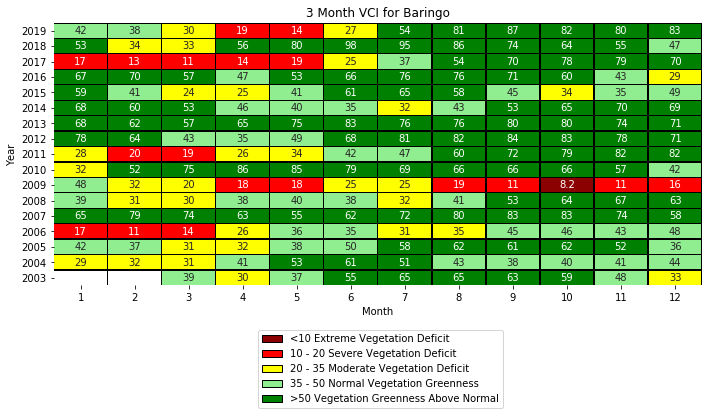

In [ ]:
#create matrix plot of monthly VCI like in NDMA's drought bulletin
county = 'Baringo'

#combine the 2 dataframes
snewdfb= pd.concat([smodisdf,smodisnewdf], axis=1).transpose()

#calculate 3 month moving average VCI for each county
for column in snewdfb:
  snewdfb[column+'3monthVCI'] = snewdfb[column].rolling(3, min_periods=3).mean()

snewdfb.to_csv('svcicounty.csv')
files.download('svcicounty.csv')  
  
#extract year and month from index
snewdfb = snewdfb.reset_index()
snewdfb['year']= snewdfb['index'].str[-4:]

snewdfb['month']= snewdfb['index'].apply(lambda st: st[st.find("i")+1:st.find("20")])

#create pivot table and sort columns so months will be in order on the graph
table= snewdfb.pivot_table(index='year', columns='month',values=county+'3monthVCI')
table = table.reindex(columns=['1','2','3','4','5','6','7','8','9','10','11','12'])

#define color scale as NDMA's VCI categories
cmap1 = matplotlib.colors.ListedColormap(['darkred', 'red', 'yellow', 'lightgreen', 'green'])
bounds=[0,10,20,35,50,100]
norm1 = matplotlib.colors.BoundaryNorm(bounds, cmap1.N)

fig, ax = plt.subplots(figsize=(10,6))
img = sns.heatmap(table, cmap=cmap1, annot=True,  norm=norm1, linewidths= 0.3, linecolor='black', cbar=False)
plt.yticks(rotation=0) 
plt.xlabel('Month')
plt.ylabel('Year')
matplotlib.axes.Axes.invert_yaxis(img)
plt.title('3 Month VCI for {0}'.format(county))

#customize legend
legend_elements = [Patch(facecolor='darkred', edgecolor='black', label='<10 Extreme Vegetation Deficit'),
                       Patch(facecolor='red', edgecolor='black', label='10 - 20 Severe Vegetation Deficit'),
                       Patch(facecolor='yellow', edgecolor='black', label='20 - 35 Moderate Vegetation Deficit'),
                       Patch(facecolor='lightgreen', edgecolor='black', label='35 - 50 Normal Vegetation Greenness'),
                       Patch(facecolor='green', edgecolor='black', label='>50 Vegetation Greenness Above Normal')]

plt.legend(handles=legend_elements, bbox_to_anchor=(0.7, -0.15))
plt.tight_layout()
plt.show()


In [ ]:
#smodis subcounty

#set up empty dataframe
smodisdf1 = pd.DataFrame()

for yr in range(2013, 2020):
  for m in range(1, 13):
    
    
    #find max and min values for 2003-2012 to use in VCI calculation
    smin = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).min()
    smax = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).max()
    
    
    smonthcollection = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
    smonth = smonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
    
    svci = (smonth.subtract(smin)).divide(smax.subtract(smin)).multiply(100) #calculate VCI
    
    #subcounty level
    smean1 = svci.reduceRegions(collection=subcounties, reducer=ee.Reducer.mean(), scale=250, tileScale=2)#tile scale is 2 so the computation won't time out
    #convert the results from Reduce.Regions into a dataframe
    sdf2 = fc2df(smean1)

    #add columns to the dataframe
    smodisdf1['monthlyvci'+str(m)+str(yr)] = sdf2['mean']
    smodisdf1['month'] = m
    smodisdf1['year'] = yr
    
    

    #set index of the dataframe to UAI gridcode and set geometry
    if (m == 12)&(yr==2019):
      smodisdf1['SUBCOUNTY'] = sdf2['ADM2_EN']
      smodisdf1.set_index('SUBCOUNTY', inplace=True, drop=True)
      break

#calculate 3 month moving average VCI for each subcounty
snewdf1 = smodisdf1.transpose()
for column in snewdf1:
  snewdf1[column+'3monthVCI'] = snewdf1[column].rolling(3, min_periods=3).mean()

#export to csv
snewdf1.to_csv('svcisubcounty.csv')
files.download('svcisubcounty.csv')

MessageError: ignored

In [ ]:
#export to csv
snewdf1.to_csv('svcisubcounty.csv')
files.download('svcisubcounty.csv')

In [ ]:
#smodis ward

#set up empty dataframe
smodisdf2 = pd.DataFrame()

for yr in range(2013, 2020):
  for m in range(1, 13):
    
    
    #find max and min values for 2003-2012 to use in VCI calculation
    smin = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).min()
    smax = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).max()
    
    
    smonthcollection = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
    smonth = smonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
    
    svci = (smonth.subtract(smin)).divide(smax.subtract(smin)).multiply(100) #calculate VCI
    
    #ward level
    smean2 = svci.reduceRegions(collection=wards, reducer=ee.Reducer.mean(), scale=250, tileScale=2)#tile scale is 2 so the computation won't time out
    #convert the results from Reduce.Regions into a dataframe
    sdf3 = fc2df(smean2)

    #add columns to the dataframe
    smodisdf2['monthlyvci'+str(m)+str(yr)] = sdf3['mean']
    smodisdf2['month'] = m
    smodisdf2['year'] = yr
    

    #set index of the dataframe to UAI gridcode and set geometry
    if (m == 12)&(yr==2019):
      swarddf = pd.DataFrame()
      swarddf['WARD'] = sdf3['CAW']
      swarddf['OBJECTID'] = sdf3['OBJECTID']
      swarddf.set_index(['OBJECTID'], inplace=True, drop=True)
      smodisdf2['OBJECTID'] = sdf3['OBJECTID']
      #there are some repeat ward names so OBJECTID is used as the index for ward level calculations
      smodisdf2.set_index(['OBJECTID'], inplace=True, drop=True)
      break

#calculate 3 month moving average VCI for each ward
snewdf2 = smodisdf2.transpose()
snewwarddf = swarddf.transpose()
for column in snewdf2:
  snewdf2[str(column)+'.3'] = snewdf2[column].rolling(3, min_periods=3).mean()
      

#add ward names after 3 month calculations are done
snewdf2 = snewdf2.append(snewwarddf)
    
#export to csv

snewdf2.to_csv('svciward.csv')
files.download('svciward.csv')

MessageError: ignored

In [ ]:
snewdf2.to_csv('svciward.csv')
files.download('svciward.csv')

In [ ]:
#emodis county

#set up empty dataframe
emodisdf = pd.DataFrame()

m = 1
yr = 2013

for yr in range(2013, 2019):
  for m in range(1, 13):
    
    
    #find max and min values for 2003-2012 to use in VCI calculation
    emin = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).min()
    emax = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).max()
    
    
    emonthcollection = emodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
    emonth = emonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
    
    evci = (emonth.subtract(emin)).divide(emax.subtract(emin)).multiply(100) #calculate VCI

    emean = evci.reduceRegions(collection=counties, reducer=ee.Reducer.mean(), scale=250, tileScale=4)#get monthly mean per UAI
    #convert the results from Reduce.Regions into a dataframe
    edf1 = fc2df(emean)

    #add columns to the dataframe
    emodisdf['vci'+str(m)+str(yr)] = edf1['mean']
    emodisdf['month'] = m
    emodisdf['year'] = yr
    

    #set index of the dataframe to UAI gridcode and set geometry
    if (m == 5)&(yr==2018):
      emodisdf['COUNTY'] = edf1['ADM1_EN']
      emodisdf.set_index('COUNTY', inplace=True, drop=True)
      break

#calculate 3 month moving average VCI for each county
newedf = emodisdf.transpose()
for column in newedf:
  newedf[column+'3monthVCI'] = newedf[column].rolling(3, min_periods=3).mean()
      

#export to csv
newedf.to_csv('evcicounty.csv')
files.download('evcicounty.csv')

In [ ]:
#emodis subcounty

#set up empty dataframe
emodisdf1 = pd.DataFrame()

for yr in range(2013, 2019):
  for m in range(1, 13):
    
    #find max and min values for 2003-2012 to use in VCI calculation
    emin = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).min()
    emax = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).max()
    
    emonthcollection = emodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
    emonth = emonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
    
    evci = (emonth.subtract(emin)).divide(emax.subtract(emin)).multiply(100) #calculate VCI
    
    
    #subcounty level
    emean1 = evci.reduceRegions(collection=subcounties, reducer=ee.Reducer.mean(), scale=250, tileScale=4)#tile scale is 4 so the computation won't time out
    #convert the results from Reduce.Regions into a dataframe
    edf2 = fc2df(emean1)

    #add columns to the dataframe
    emodisdf1['monthlyvci'+str(m)+str(yr)] = edf2['mean']
    emodisdf1['month'] = m
    emodisdf1['year'] = yr   

    #set index of the dataframe to UAI gridcode and set geometry
    if (m == 5)&(yr==2018):
      emodisdf1['SUBCOUNTY'] = edf2['ADM2_EN']
      emodisdf1.set_index('SUBCOUNTY', inplace=True, drop=True)
      break


#calculate 3 month moving average VCI for each subcounty
enewdf1 = emodisdf1.transpose()
for column in enewdf1:
  enewdf1[column+'3monthVCI'] = enewdf1[column].rolling(3, min_periods=3).mean()

      
      
#export to csv
enewdf1.to_csv('evcisubcounty.csv')
files.download('evcisubcounty.csv')

In [ ]:
#emodis ward

#set up empty dataframe
emodisdf2 = pd.DataFrame()

for yr in range(2013, 2019):
  for m in range(1, 13):
    
    #find max and min values for 2003-2012 to use in VCI calculation
    emin = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).min()
    emax = smodis.filter(ee.Filter.calendarRange(2003, 2012, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).max()
    
    emonthcollection = emodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))
    emonth = emonthcollection.reduce(ee.Reducer.mean()) #mean monthly NDVI
    
    evci = (emonth.subtract(emin)).divide(emax.subtract(emin)).multiply(100) #calculate VCI

    #ward level
    emean2 = evci.reduceRegions(collection=wards, reducer=ee.Reducer.mean(), scale=250, tileScale=2)#tile scale is 2 so the computation won't time out
    #convert the results from Reduce.Regions into a dataframe
    edf3 = fc2df(emean2)

    #add columns to the dataframe
    emodisdf2['monthlyvci'+str(m)+str(yr)] = edf3['mean']
    emodisdf2['month'] = m
    emodisdf2['year'] = yr
    

    #set index of the dataframe to UAI gridcode and set geometry
    if (m == 5)&(yr==2018):
      warddf = pd.DataFrame()
      warddf['WARD'] = edf3['CAW']
      warddf['OBJECTID'] = edf3['OBJECTID']
      warddf.set_index(['OBJECTID'], inplace=True, drop=True)
      emodisdf2['OBJECTID'] = edf3['OBJECTID']
      #there are some repeat ward names so OBJECTID is used as the index for ward level calculations
      emodisdf2.set_index(['OBJECTID'], inplace=True, drop=True)
      break

#calculate 3 month moving average VCI for each ward
enewdf2 = emodisdf2.transpose()
newwarddf = warddf.transpose()

for column in enewdf2:
  enewdf2[str(column)+'.3'] = enewdf2[column].rolling(3, min_periods=3).mean()


#add ward names after 3 month calculations are done
enewdf2 = enewdf2.append(newwarddf)

#export to csv
enewdf2.to_csv('evciward.csv')
files.download('evciward.csv')